In [1]:
# --- Core and Data Handling Libraries ---
import os
import numpy as np
import pandas as pd
from multiprocessing import Pool

# --- Signal Processing & Machine Learning ---
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, accuracy_score,
                             roc_auc_score, ConfusionMatrixDisplay)

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Constants ---
SAMPLING_RATE = 256  # Sampling frequency in Hz
TRAIN_FOLDER = '/kaggle/input/Alcoholics/SMNI_CMI_TRAIN'
TEST_FOLDER = '/kaggle/input/Alcoholics/SMNI_CMI_TEST'

In [2]:
def load_csv(file_path):
    """Loads a single CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

# Get paths for all training and testing CSV files
train_files_path = [os.path.join(TRAIN_FOLDER, f) for f in os.listdir(TRAIN_FOLDER) if f.endswith('.csv')]
test_files_path = [os.path.join(TEST_FOLDER, f) for f in os.listdir(TEST_FOLDER) if f.endswith('.csv')]

# Load data in parallel
with Pool(processes=os.cpu_count()) as pool:
    train_data = pool.map(load_csv, train_files_path)
    test_data = pool.map(load_csv, test_files_path)

# Concatenate all data into a single DataFrame
full_df = pd.concat(train_data + test_data, ignore_index=True)

# Separate data for alcoholic and control groups
alcohol_data = full_df[full_df['subject identifier'] == 'a'].copy()
control_data = full_df[full_df['subject identifier'] == 'c'].copy()

print("Data loaded successfully.")
print(f"Alcoholic group shape: {alcohol_data.shape}")
print(f"Control group shape: {control_data.shape}")

Data loaded successfully.
Alcoholic group shape: (7782400, 10)
Control group shape: (7749632, 10)


In [3]:
def bandpass_filter(signal, low_freq, high_freq, fs, order=5):
    """Applies a bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

# Define a lambda function to apply the filter
filter_func = lambda x: bandpass_filter(x, 1, 30, SAMPLING_RATE)

# Group by each unique signal and apply the filter
grouping_keys = ['name', 'trial number', 'sensor position']
alcohol_data['filtered_value'] = alcohol_data.groupby(grouping_keys)['sensor value'].transform(filter_func)
control_data['filtered_value'] = control_data.groupby(grouping_keys)['sensor value'].transform(filter_func)

print("Filtering complete.")

Filtering complete.


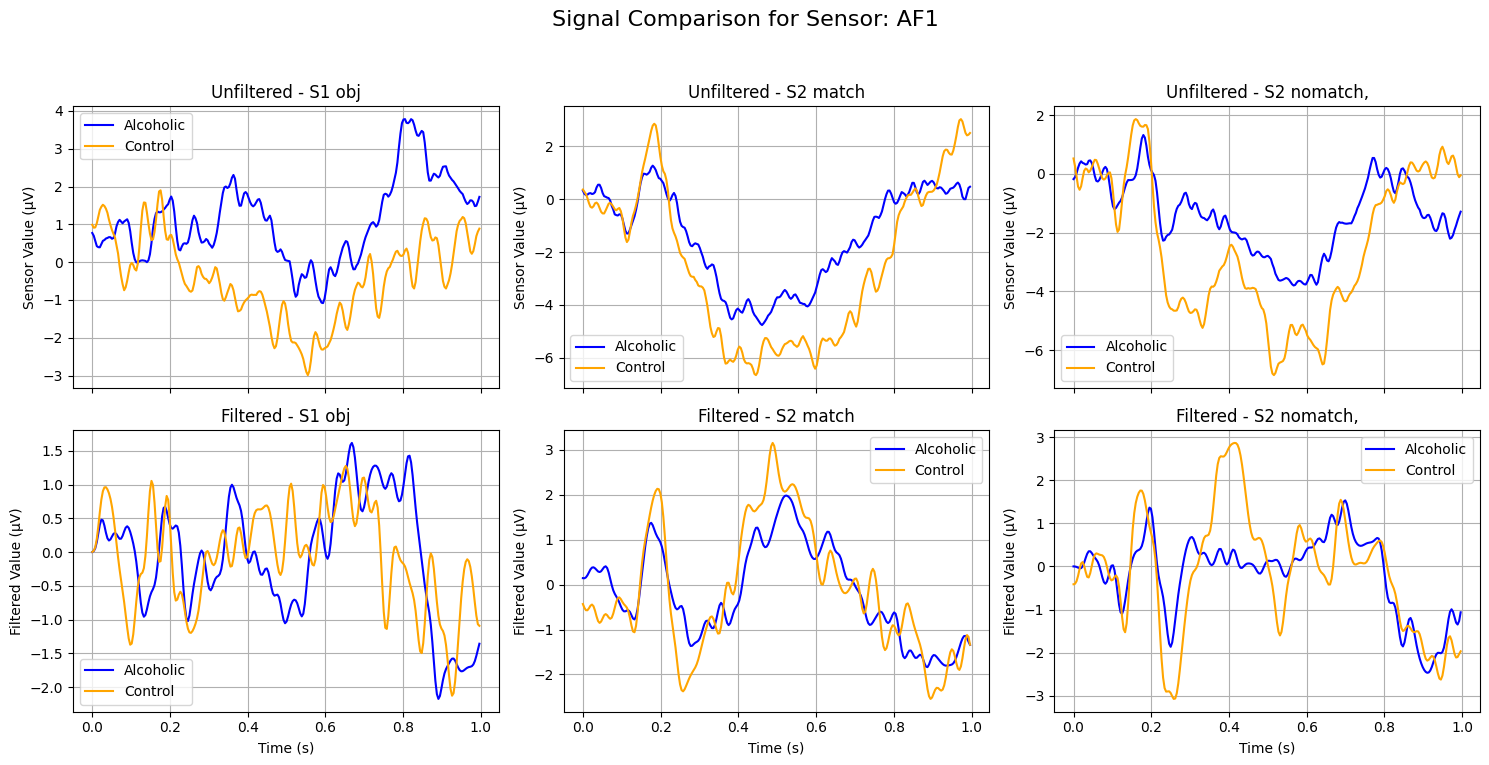

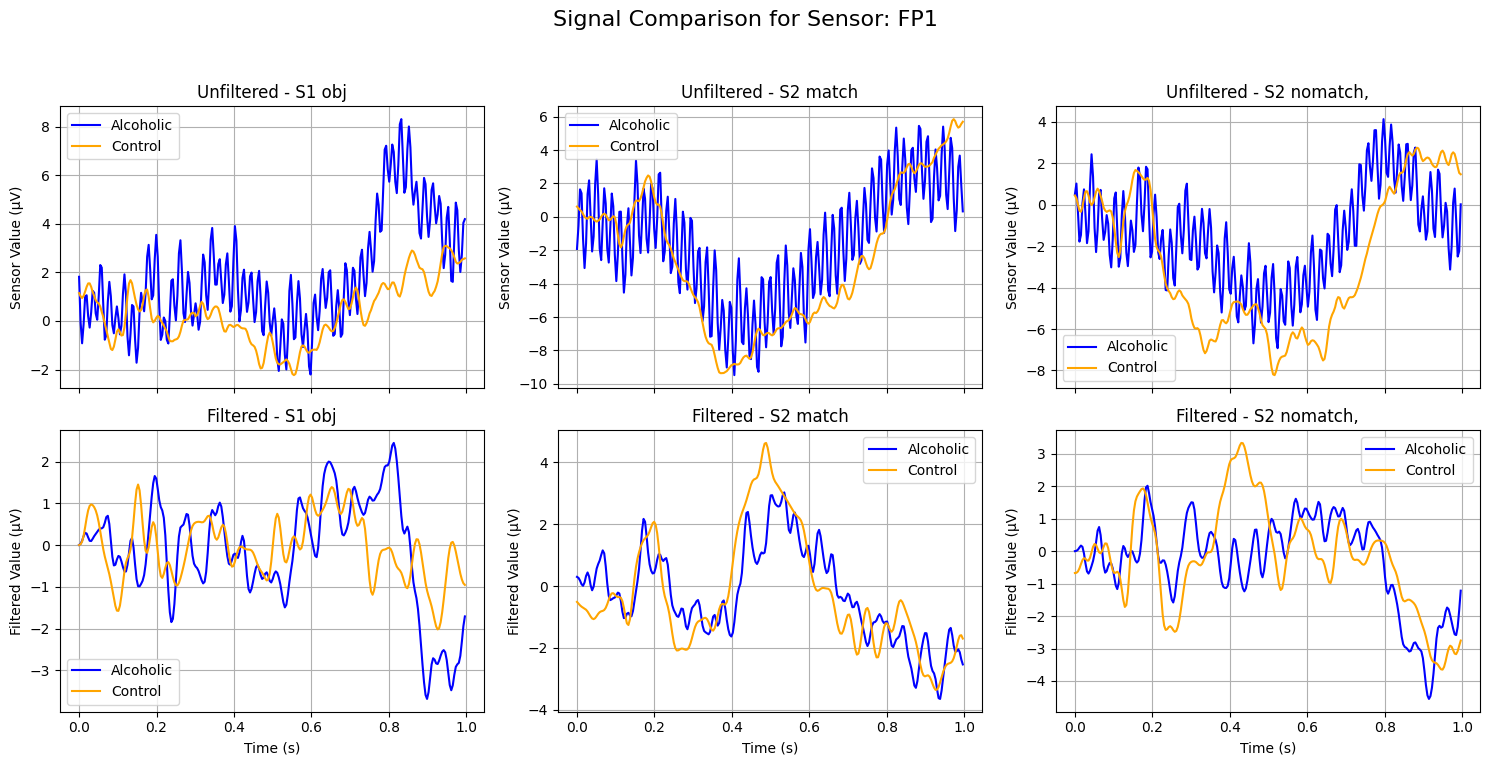

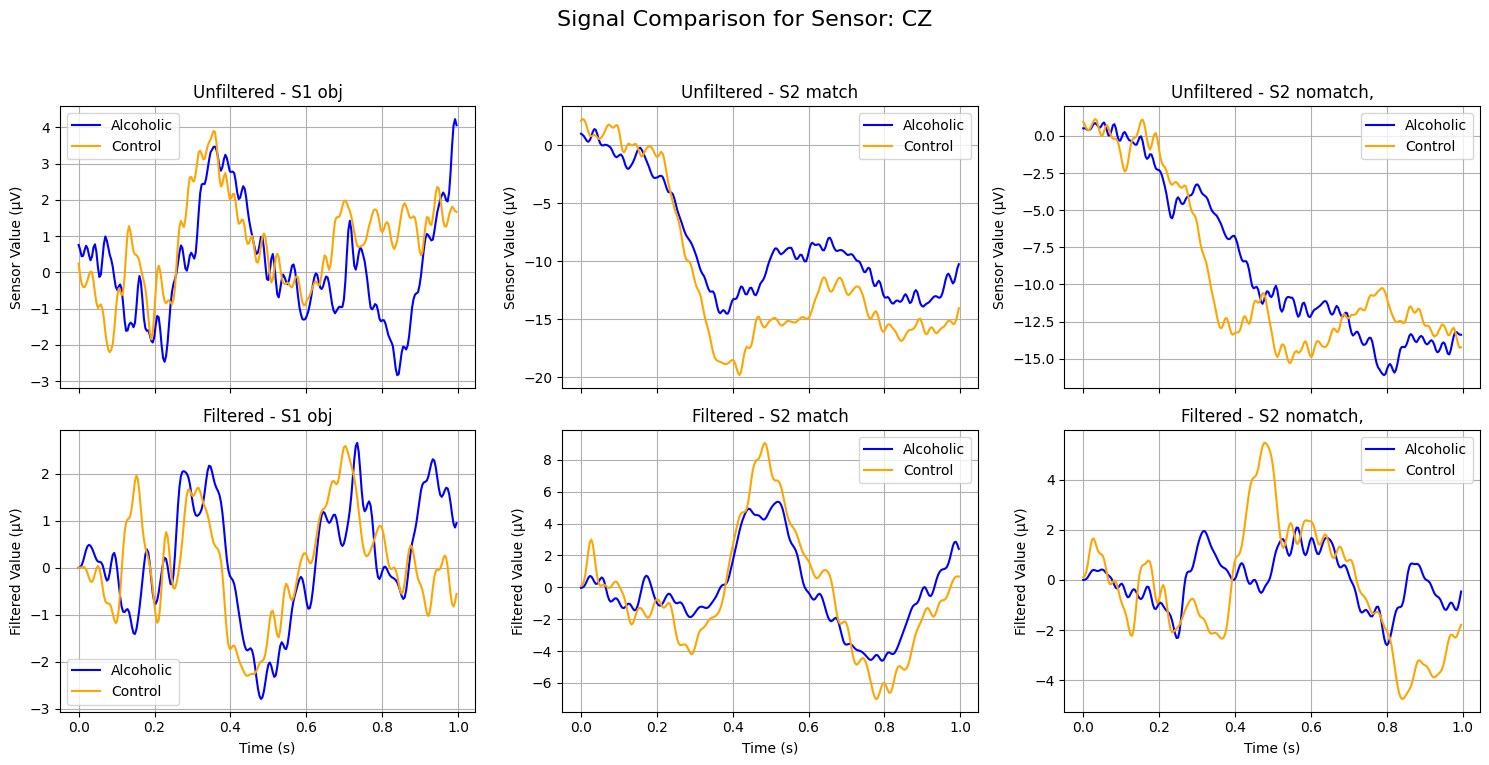

In [4]:
def plot_data_comparison(unfiltered_alc, unfiltered_ctrl, filtered_alc, filtered_ctrl, sensors):
    """Plots a side-by-side comparison of unfiltered and filtered signals."""
    for sensor in sensors:
        conditions = unfiltered_alc['matching condition'].unique()
        fig, axes = plt.subplots(2, len(conditions), figsize=(15, 8), sharex=True)
        fig.suptitle(f'Signal Comparison for Sensor: {sensor}', fontsize=16)

        for i, condition in enumerate(conditions):
            # Plot Unfiltered Data
            ax1 = axes[0, i]
            unfiltered_alc.loc[(unfiltered_alc['sensor position'] == sensor) & (unfiltered_alc['matching condition'] == condition)].groupby('time')['sensor value'].mean().plot(ax=ax1, label='Alcoholic', color='blue')
            unfiltered_ctrl.loc[(unfiltered_ctrl['sensor position'] == sensor) & (unfiltered_ctrl['matching condition'] == condition)].groupby('time')['sensor value'].mean().plot(ax=ax1, label='Control', color='orange')
            ax1.set_title(f'Unfiltered - {condition}')
            ax1.set_ylabel('Sensor Value (μV)')
            ax1.legend()
            ax1.grid(True)

            # Plot Filtered Data
            ax2 = axes[1, i]
            filtered_alc.loc[(filtered_alc['sensor position'] == sensor) & (filtered_alc['matching condition'] == condition)].groupby('time')['filtered_value'].mean().plot(ax=ax2, label='Alcoholic', color='blue')
            filtered_ctrl.loc[(filtered_ctrl['sensor position'] == sensor) & (filtered_ctrl['matching condition'] == condition)].groupby('time')['filtered_value'].mean().plot(ax=ax2, label='Control', color='orange')
            ax2.set_title(f'Filtered - {condition}')
            ax2.set_xlabel('Time (s)')
            ax2.set_ylabel('Filtered Value (μV)')
            ax2.legend()
            ax2.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Select sensors to visualize
sensors_to_plot = ['AF1', 'FP1', 'CZ']
plot_data_comparison(alcohol_data, control_data, alcohol_data, control_data, sensors_to_plot)

In [5]:
def standardize_names(df):
    """Standardizes sensor and condition names in the DataFrame."""
    df_std = df.copy()
    
    # Clean up matching condition string
    df_std['matching condition'] = df_std['matching condition'].str.replace('S2 nomatch,', 'S2 nomatch', regex=False)

    # Define name mappings
    name_map = {
        'AF1': 'AF3', 'AF2': 'AF4', 'PO1': 'PO3', 'PO2': 'PO4',
        'FP1': 'Fp1', 'FP2': 'Fp2', 'CPZ': 'CPz', 'FZ': 'Fz',
        'CZ': 'Cz', 'PZ': 'Pz', 'FPZ': 'Fpz', 'AFZ': 'AFz',
        'FCZ': 'FCz', 'POZ': 'POz', 'OZ': 'Oz'
    }
    
    # Apply mapping using .replace()
    df_std['sensor position'] = df_std['sensor position'].replace(name_map)
    
    return df_std

# Apply standardization to both datasets
alcohol_data_std = standardize_names(alcohol_data)
control_data_std = standardize_names(control_data)

print("Sensor names have been standardized.")
print("\nUnique sensor names in alcoholic data:", sorted(alcohol_data_std['sensor position'].unique()))
print("\nUnique sensor names in control data:  ", sorted(control_data_std['sensor position'].unique()))

Sensor names have been standardized.

Unique sensor names in alcoholic data: ['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y', 'nd']

Unique sensor names in control data:   ['AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCz', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y', 'nd']


In [6]:
# Aggregate by time and sensor, then pivot
eeg_alcoholic_pivoted = alcohol_data_std.groupby(['time', 'sensor position'])['filtered_value'].mean().reset_index().pivot(index='time', columns='sensor position', values='filtered_value')
eeg_control_pivoted = control_data_std.groupby(['time', 'sensor position'])['filtered_value'].mean().reset_index().pivot(index='time', columns='sensor position', values='filtered_value')

# Drop columns that are not standard sensor names if they exist
cols_to_drop = [col for col in ['X', 'Y', 'nd'] if col in eeg_alcoholic_pivoted.columns]
eeg_alcoholic_pivoted = eeg_alcoholic_pivoted.drop(columns=cols_to_drop)
eeg_control_pivoted = eeg_control_pivoted.drop(columns=cols_to_drop)


print("Pivoted Alcoholic Data Head:")
display(eeg_alcoholic_pivoted.head())

Pivoted Alcoholic Data Head:


sensor position,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.048872,0.056019,0.081386,0.084876,0.049068,-0.005420,-0.014727,0.014849,0.000932,0.014282,...,-0.022361,-0.021899,-0.017982,-0.049248,-0.018444,-0.008410,0.015926,0.015598,-0.000971,-0.019630
0.003906,0.051082,0.051421,0.092571,0.079526,0.047598,0.004669,-0.003645,0.017206,0.006437,0.031516,...,-0.013473,-0.021970,0.001514,-0.028247,-0.013790,-0.004987,0.029445,0.008931,0.020929,-0.016894
0.007812,0.069485,0.057183,0.114443,0.070333,0.060199,0.030478,0.014014,0.033897,0.010834,0.056820,...,-0.000869,-0.021228,0.036817,0.016496,-0.006474,-0.002942,0.044434,-0.001625,0.050815,-0.010430
0.011719,0.111109,0.078884,0.154809,0.054928,0.093405,0.074846,0.032759,0.075172,0.008461,0.096800,...,0.020762,-0.016926,0.094428,0.087519,0.008239,-0.001002,0.064724,-0.019074,0.094131,-0.006407
0.015625,0.172373,0.116681,0.214382,0.034674,0.144572,0.125892,0.041600,0.140656,-0.003016,0.150385,...,0.053751,-0.008248,0.173426,0.168947,0.031875,0.002812,0.095414,-0.038206,0.148412,-0.017332


Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        77
           1       0.92      0.92      0.92        77

    accuracy                           0.92       154
   macro avg       0.92      0.92      0.92       154
weighted avg       0.92      0.92      0.92       154



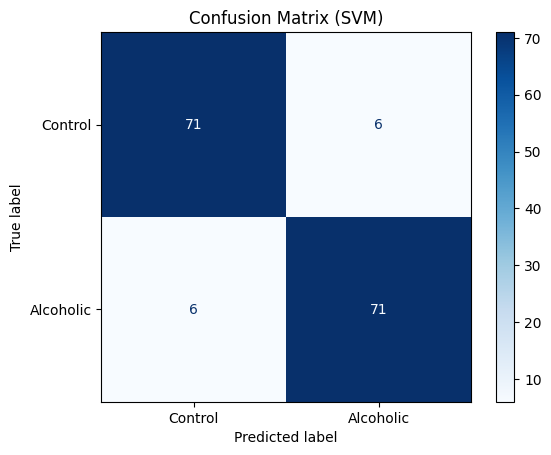

In [7]:
# Add labels: 1 for alcoholic, 0 for control
eeg_alcoholic_pivoted['label'] = 1
eeg_control_pivoted['label'] = 0

# Combine datasets
eeg_combined = pd.concat([eeg_alcoholic_pivoted, eeg_control_pivoted], ignore_index=True)

# Define features (X) and target (y)
X = eeg_combined.drop('label', axis=1)
y = eeg_combined['label']

# Split data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM model
svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm.predict(X_test_scaled)

# --- Evaluation ---
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control', 'Alcoholic'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (SVM)')
plt.show()

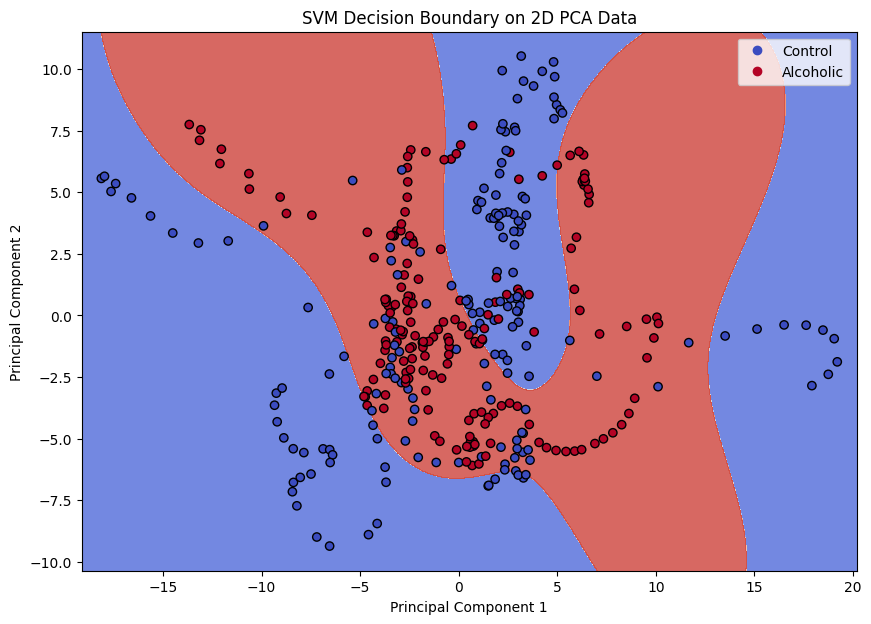

In [8]:
# Reduce feature space to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Train a new SVM on the 2D PCA-transformed data
svm_pca = SVC(kernel='rbf', C=1, gamma='scale')
svm_pca.fit(X_train_pca, y_train)

# Create a mesh grid for plotting
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict on the mesh grid to get the decision boundary
Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title('SVM Decision Boundary on 2D PCA Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Control', 'Alcoholic'])
plt.show()

In [9]:
# Calculate metrics
f1 = f1_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)
auc_score = roc_auc_score(y_test, svm.decision_function(X_test_scaled))

# Specificity = True Negatives / (True Negatives + False Positives)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm).ravel()
specificity = tn / (tn + fp)

# Print metrics
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC (Area Under Curve): {auc_score:.4f}")

F1 Score: 0.9221
Precision: 0.9221
Recall (Sensitivity): 0.9221
Specificity: 0.9221
Accuracy: 0.9221
AUC (Area Under Curve): 0.9874


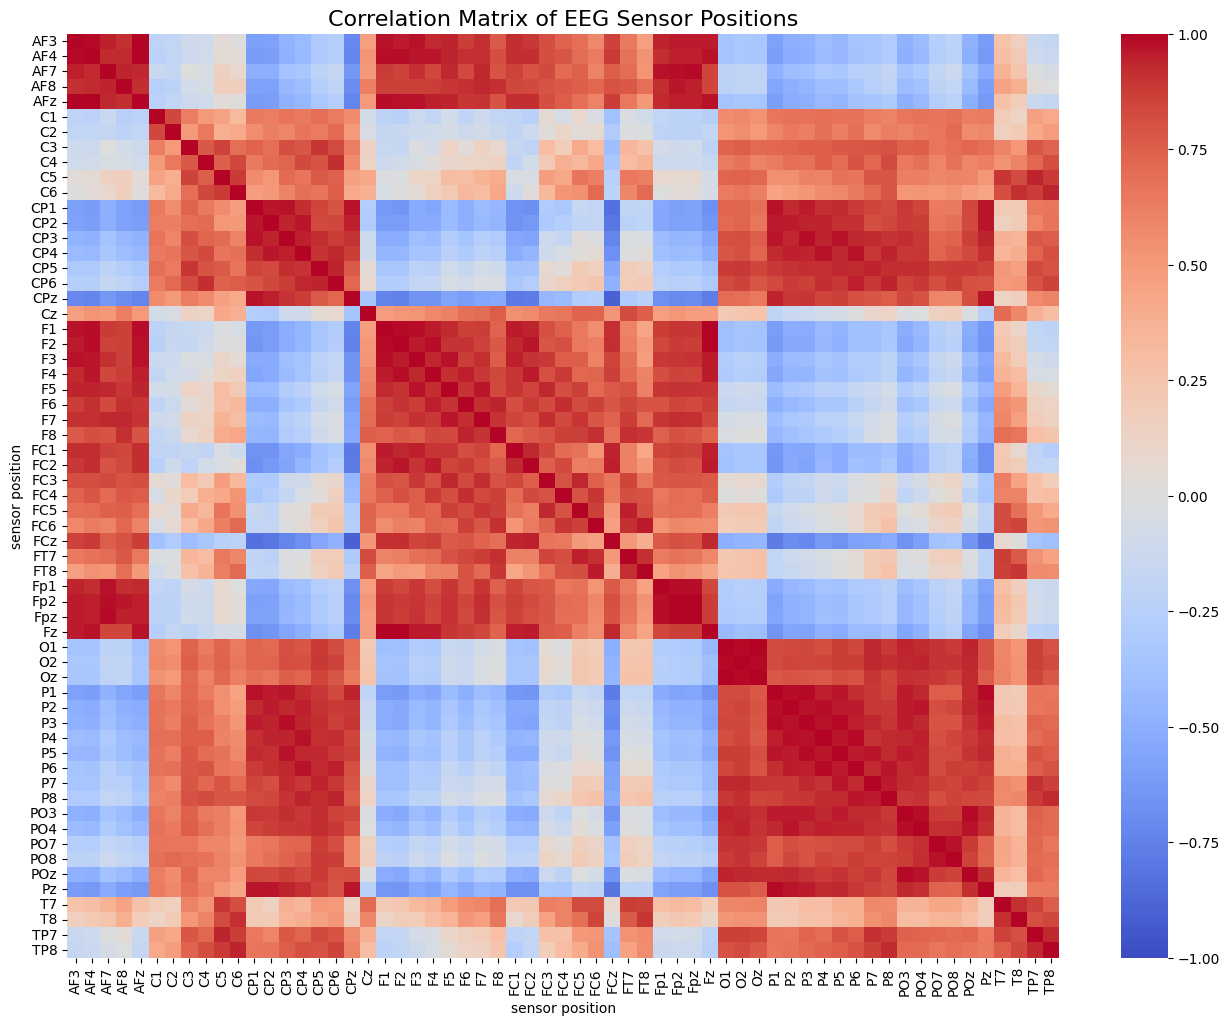

In [10]:
# Calculate the correlation matrix
correlation_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of EEG Sensor Positions', fontsize=16)
plt.show()

Implications for Alcoholism:
EEG as a Biomarker:

The perfect classification suggests that EEG signals carry distinctive features that differentiate alcoholic individuals from controls, indicating specific brain activity patterns associated with alcoholism.
Neural Markers:

The results could point to neural biomarkers related to brain regions involved in decision-making, cognitive control, and emotional processing, which are affected in alcoholism.
Early Detection:

EEG-based classification could help in early detection of alcohol use disorder, offering a non-invasive method for identifying individuals at risk and guiding interventions.

CONCLUSION-


We loaded and preprocessed EEG data for alcoholic and control groups, standardizing the data and training an SVM classifier to distinguish between the two groups. We performed dimensionality reduction using PCA to visualize the decision boundary, then evaluated the model's performance using metrics like accuracy, precision, recall, and F1 score. Additionally, we analyzed the correlations between sensor positions and explored potential neural patterns related to alcoholism.